<a target="_blank" href="https://colab.research.google.com/github/Techtonique/nnetsauce/blob/master/nnetsauce/demo/thierrymoudiki_20240106_LazyDeepMTS.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

## **LazyDeepMTS in nnetsauce v0.16.3 for Multivariate time series (MTS)**

Keep in mind that VAR and VECM aren't thoroughly trained here. `nnetsauce.MTS` isn't really tuned either. This is just a demo. To finish, a probabilistic error metric is better for models capturing forecasting uncertainty.

**Contents**

- 1 - Install
- 2 - MTS
- 2 - 1 nnetsauce.MTS
- 2 - 2 statsmodels VAR
- 2 - 3 statsmodels VECM

# **1 - Install**

In [1]:
!pip uninstall nnetsauce --yes

Found existing installation: nnetsauce 0.16.3
Uninstalling nnetsauce-0.16.3:
  Successfully uninstalled nnetsauce-0.16.3


In [2]:
!pip install git+https://github.com/Techtonique/nnetsauce.git --upgrade --no-cache-dir

  Cloning https://github.com/Techtonique/nnetsauce.git to /private/var/folders/cp/q8d6040n3m38d22z3hkk1zc40000gn/T/pip-req-build-ctaux_j_
  Running command git clone --filter=blob:none --quiet https://github.com/Techtonique/nnetsauce.git /private/var/folders/cp/q8d6040n3m38d22z3hkk1zc40000gn/T/pip-req-build-ctaux_j_
  Resolved https://github.com/Techtonique/nnetsauce.git to commit d4f6993946980944b48a1c50e5233f5a0167c5c7
  Preparing metadata (setup.py) ... done
  Created wheel for nnetsauce: filename=nnetsauce-0.16.3-py2.py3-none-any.whl size=152402 sha256=bd657656a7eac9041e821755881ad109ab0a460bbed3bbe2f3810cfd31874ced
  Stored in directory: /private/var/folders/cp/q8d6040n3m38d22z3hkk1zc40000gn/T/pip-ephem-wheel-cache-56u9lcia/wheels/b2/f4/2f/6b092057e686c4b6fe55485af460fc8c48ff887066a8ae1e6c
Successfully built nnetsauce


In [33]:
import nnetsauce as ns
import numpy as np
import pandas as pd
import statsmodels.api as sm
from statsmodels.tsa.api import VAR
from statsmodels.tsa.base.datetools import dates_from_str
from sklearn.linear_model import LassoCV, Ridge 
from sklearn.neighbors import KNeighborsRegressor
from statsmodels.tsa.api import VAR
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.vector_ar.vecm import VECM, select_order
from statsmodels.tsa.base.datetools import dates_from_str

# **2 - LazyDeepMTS**

Macro data

In [34]:
# some example data
mdata = sm.datasets.macrodata.load_pandas().data

# prepare the dates index
dates = mdata[['year', 'quarter']].astype(int).astype(str)

quarterly = dates["year"] + "Q" + dates["quarter"]

quarterly = dates_from_str(quarterly)

print(mdata.head())

#mdata = mdata[['realgdp','realcons','realinv', 'realgovt',
#               'realdpi', 'cpi', 'm1', 'tbilrate', 'unemp',
#               'pop']]

mdata = mdata[['realgovt', 'tbilrate']]

mdata.index = pd.DatetimeIndex(quarterly)

data = np.log(mdata).diff().dropna()

#data = mdata

display(data)

     year  quarter  realgdp  realcons  realinv  realgovt  realdpi   cpi  \
0 1959.00     1.00  2710.35   1707.40   286.90    470.05  1886.90 28.98   
1 1959.00     2.00  2778.80   1733.70   310.86    481.30  1919.70 29.15   
2 1959.00     3.00  2775.49   1751.80   289.23    491.26  1916.40 29.35   
3 1959.00     4.00  2785.20   1753.70   299.36    484.05  1931.30 29.37   
4 1960.00     1.00  2847.70   1770.50   331.72    462.20  1955.50 29.54   

      m1  tbilrate  unemp    pop  infl  realint  
0 139.70      2.82   5.80 177.15  0.00     0.00  
1 141.70      3.08   5.10 177.83  2.34     0.74  
2 140.50      3.82   5.30 178.66  2.74     1.09  
3 140.00      4.33   5.60 179.39  0.27     4.06  
4 139.60      3.50   5.20 180.01  2.31     1.19  


,realgovt,tbilrate
1959-06-30,0.02,0.09
1959-09-30,0.02,0.22
1959-12-31,-0.01,0.13
1960-03-31,-0.05,-0.21
1960-06-30,-0.00,-0.27
...,...,...
2008-09-30,0.03,-0.40
2008-12-31,0.02,-2.28
2009-03-31,-0.01,0.61
2009-06-30,0.03,-0.20


In [35]:
df = data
#df.set_index('Month', inplace=True)
df.index.rename('date')

idx_train = int(df.shape[0]*0.8)
idx_end = df.shape[0]
df_train = df.iloc[0:idx_train,]
df_test = df.iloc[idx_train:idx_end,]

regr_mts = ns.LazyDeepMTS(verbose=1, ignore_warnings=True, custom_metric=None,
                      lags = 4, n_hidden_features=5, n_clusters=2, random_state=1)
models, predictions = regr_mts.fit(df_train, df_test)
model_dictionary = regr_mts.provide_models(df_train, df_test)

100%|██████████| 31/31 [00:33<00:00,  1.07s/it]


In [36]:
display(models)

,RMSE,MAE,MPL,Time Taken
Model,,,,
DeepMTS(Ridge),0.22,0.12,0.06,1.06
DeepMTS(KNeighborsRegressor),0.22,0.12,0.06,0.72
DeepMTS(RidgeCV),0.22,0.12,0.06,1.28
DeepMTS(LassoLarsIC),0.22,0.12,0.06,0.84
DeepMTS(SGDRegressor),0.22,0.12,0.06,1.41
DeepMTS(TweedieRegressor),0.22,0.12,0.06,1.00
DeepMTS(BayesianRidge),0.22,0.12,0.06,0.67
DeepMTS(LarsCV),0.22,0.12,0.06,1.97
DeepMTS(LassoLars),0.22,0.12,0.06,0.79


In [37]:
[(models.index[i], models['RMSE'].values[i]) for i in range(models.shape[0])]

[('DeepMTS(Ridge)', 0.21724638991414208),
 ('DeepMTS(KNeighborsRegressor)', 0.21743476834878206),
 ('DeepMTS(RidgeCV)', 0.21847825353248113),
 ('DeepMTS(LassoLarsIC)', 0.21979281814079593),
 ('DeepMTS(SGDRegressor)', 0.22022462798668632),
 ('DeepMTS(TweedieRegressor)', 0.22071851071024387),
 ('DeepMTS(BayesianRidge)', 0.22076034936823258),
 ('DeepMTS(LarsCV)', 0.22085586713881272),
 ('DeepMTS(LassoLars)', 0.22144307521733578),
 ('DeepMTS(Lasso)', 0.22144307521733578),
 ('DeepMTS(ElasticNet)', 0.22144307521733578),
 ('DeepMTS(DummyRegressor)', 0.22144307521733578),
 ('DeepMTS(LassoLarsCV)', 0.22159142804367385),
 ('DeepMTS(ElasticNetCV)', 0.22159594791065867),
 ('DeepMTS(LassoCV)', 0.22159608263480224),
 ('DeepMTS(AdaBoostRegressor)', 0.22188260412400237),
 ('DeepMTS(LinearSVR)', 0.2234016330674038),
 ('DeepMTS(DecisionTreeRegressor)', 0.22476806158319546),
 ('DeepMTS(ExtraTreeRegressor)', 0.22576869064740954),
 ('DeepMTS(ExtraTreesRegressor)', 0.2294591360456513),
 ('DeepMTS(HuberRegre

## **2 - 1 - `nnetsauce.MTS`**

In [39]:
regr = ns.MTS(obj = KNeighborsRegressor(),
              lags = 1, n_hidden_features=3,
              n_clusters=0, replications = 250,
              kernel = "gaussian", verbose = 1)

In [40]:
regr.fit(df_train)


 Adjusting KNeighborsRegressor to multivariate time series... 
 


100%|██████████| 2/2 [00:00<00:00, 141.95it/s]


 Simulate residuals using gaussian kernel... 




 Best parameters for gaussian kernel: {'bandwidth': 0.026886248066529384} 



MTS(kernel='gaussian', n_clusters=0, n_hidden_features=3,
    obj=KNeighborsRegressor(), replications=250, verbose=1)

In [41]:
res = regr.predict(h=df_test.shape[0], level=95)

100%|██████████| 250/250 [00:00<00:00, 4722.70it/s]


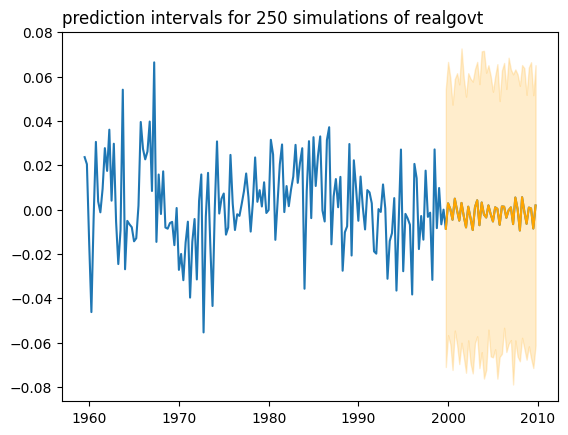

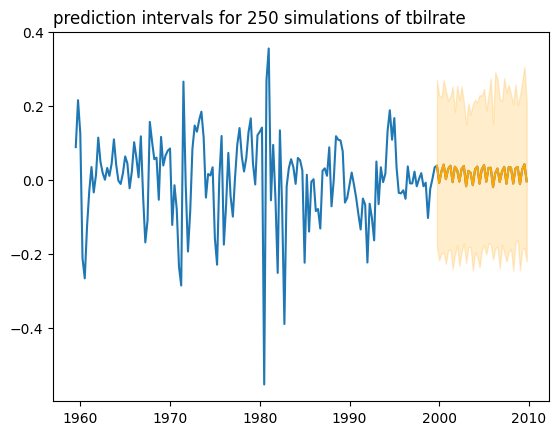

In [42]:
regr.plot("realgovt")
regr.plot("tbilrate")

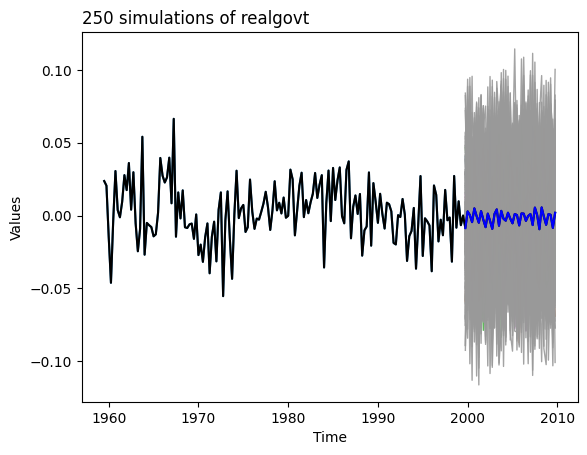

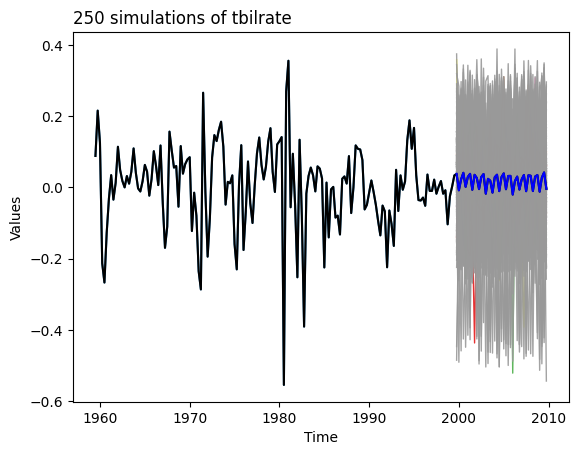

In [43]:
regr.plot("realgovt", type_plot = "spaghetti")
regr.plot("tbilrate", type_plot = "spaghetti")


## **2 - 2 - VAR**

In [44]:
model = VAR(df_train)
results = model.fit(maxlags=5, ic='aic')
lag_order = results.k_ar
VAR_preds = results.forecast(df_train.values[-lag_order:], df_test.shape[0])

/Users/t/Documents/Python_Packages/nnetsauce/venv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency Q-DEC will be used.
  self._init_dates(dates, freq)


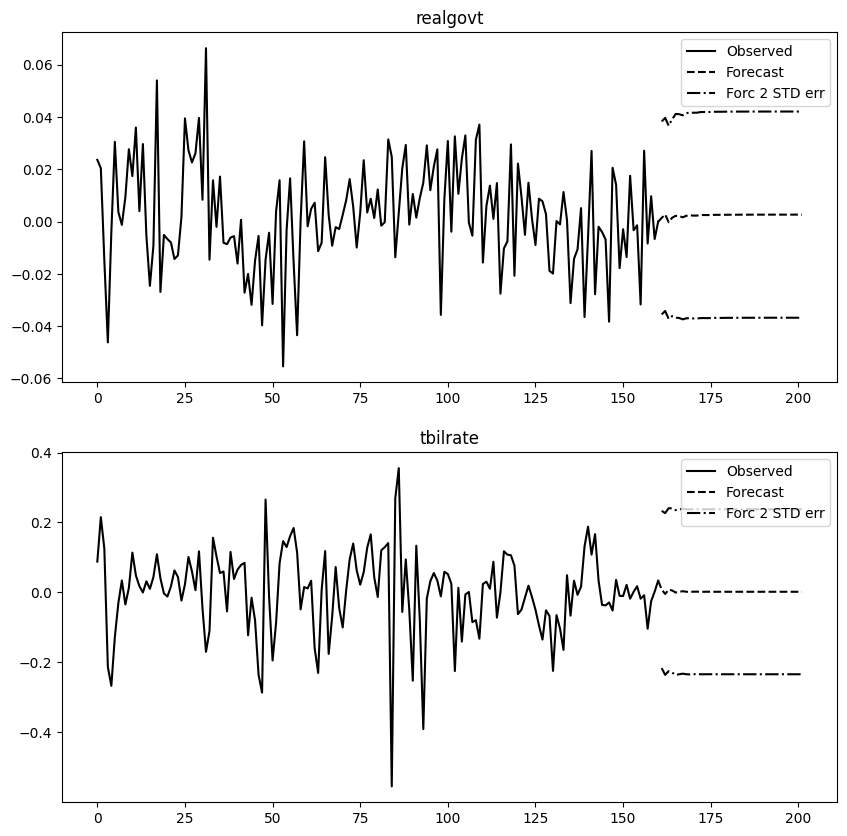

In [45]:
results.plot_forecast(steps = df_test.shape[0]);

## **2 - 3 - VECM**

In [46]:
model = VECM(df_train, k_ar_diff=2, coint_rank=2)
vecm_res = model.fit()
vecm_res.gamma.round(4)
vecm_res.summary()
vecm_res.predict(steps=df_test.shape[0])
forecast, lower, upper = vecm_res.predict(df_test.shape[0], 0.05)

/Users/t/Documents/Python_Packages/nnetsauce/venv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency Q-DEC will be used.
  self._init_dates(dates, freq)


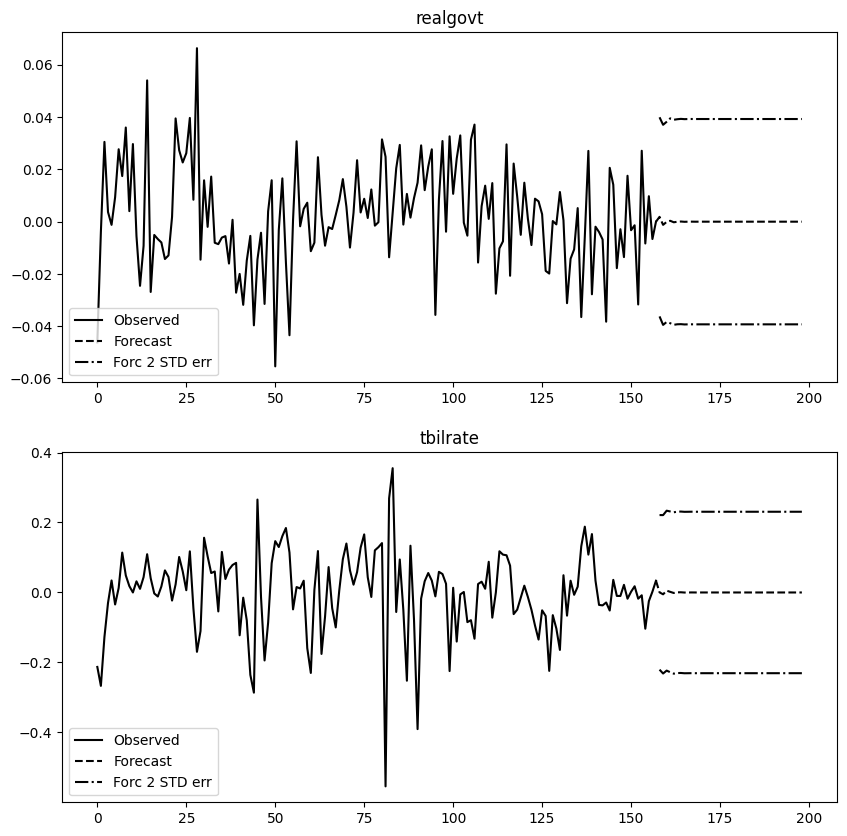

In [47]:
vecm_res.plot_forecast(steps = df_test.shape[0])

out-of-sample errors

In [48]:
display([("nnetsauce.MTS+"+models.index[i], models["RMSE"].iloc[i]) for i in range(3)])
display(('VAR', mean_squared_error(df_test.values, VAR_preds, squared=False)))
display(('VECM', mean_squared_error(df_test.values, forecast, squared=False)))

[('nnetsauce.MTS+DeepMTS(Ridge)', 0.21724638991414208),
 ('nnetsauce.MTS+DeepMTS(KNeighborsRegressor)', 0.21743476834878206),
 ('nnetsauce.MTS+DeepMTS(RidgeCV)', 0.21847825353248113)]

('VAR', 0.22128770514262766)

('VECM', 0.22170093788693068)